In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import json
import cv2

from torchvision.transforms import Compose
from torch.utils.data._utils.collate import default_collate
from data.nyu_depth_v2.nyuv2_dataset import to_tensor
from data.captured.parula import parula, parula_black
from models.discretize import SI
from models.mde import MDE
from models.mde_transient import MDETransient, TransientPreprocessor, refl_est_green
from models.midas import MiDaS
from models.midas import midas_preprocess

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [56]:
data_dir = Path('.')/'data'/'captured'/'raw'/'scanned_diffused'
calib_dir = data_dir/'calib'

In [57]:
# Load calibration data, kinect images
def registration_depth_to_color(mx, my, color, depth, depth_q=0.01, color_q=0.002199):
    """
    Verbatim almost-C++ from OpenKinect libfreenect2
    :param mx: x coordinate in depth image
    :param my: y coordinate in depth image
    :param color: ColorCameraParams object
    :param depth_q: Probably don't change, hardcoded value from Kinect SDK
    :param color_q: Probably don't change, hardcoded value from Kinect SDK
    :return:
        rx: x coordinate in color image
        ry: y coordinate in color image
    """

    mx = (mx - depth["cx"]) * depth_q
    my = (my - depth["cy"]) * depth_q

    wx = \
        (mx * mx * mx * color["mx_x3y0"]) + (my * my * my * color["mx_x0y3"]) + \
        (mx * mx * my * color["mx_x2y1"]) + (my * my * mx * color["mx_x1y2"]) + \
        (mx * mx * color["mx_x2y0"]) + (my * my * color["mx_x0y2"]) + (mx * my * color["mx_x1y1"]) + \
        (mx * color["mx_x1y0"]) + (my * color["mx_x0y1"]) + (color["mx_x0y0"])

    wy = \
        (mx * mx * mx * color["my_x3y0"]) + (my * my * my * color["my_x0y3"]) + \
        (mx * mx * my * color["my_x2y1"]) + (my * my * mx * color["my_x1y2"]) + \
        (mx * mx * color["my_x2y0"]) + (my * my * color["my_x0y2"]) + (mx * my * color["my_x1y1"]) + \
        (mx * color["my_x1y0"]) + (my * color["my_x0y1"]) + (color["my_x0y0"])

    rx = (wx / (color["fx"] * color_q)) - (color["shift_m"] / color["shift_d"])
    ry = (wy / color_q) + color["cy"]
    return rx, ry


def registration_apply(dx, dy, z, color, depth):
    """
    Implements Registration::apply() mapping an (dx, dy, dz) coordinate to
    the corresponding coordinate in the color image.
    z is depth in mm
    """
    dz = z[dy, dx]
    rx, ry = registration_depth_to_color(dx, dy, color, depth)
    cy = ry
    rx += color["shift_m"] / dz
    cx = rx * color["fx"] + color["cx"]
    return cx, cy

with open(calib_dir/'colorcameraparams.json') as f:
    color_camera_params = json.load(f)
with open(calib_dir/'ircameraparams.json') as f:
    ir_camera_params = json.load(f)
fc_kinect_rgb = (color_camera_params['fx'], color_camera_params['fy'])

a = np.load(data_dir/'kinect.npy', allow_pickle=True)[()]
crop = (200, 1080, 485, 1365)
rgb = a['color']
rgb_cropped = rgb[crop[0]:crop[1], crop[2]:crop[3], :]
depth = a['depth']

# Get ground truth depth
depth_in_color_coords = np.zeros((rgb.shape[0], rgb.shape[1]))
for dy in range(depth.shape[0]):
    for dx in range(depth.shape[1]):
        if depth[dy, dx] > 0:
            cx, cy = registration_apply(dx, dy, depth, color_camera_params, ir_camera_params)
            cx = np.clip(np.floor(cx), a_min=0, a_max=1919).astype(int)
            cy = np.clip(np.floor(cy), a_min=0, a_max=1079).astype(int)
            depth_in_color_coords[cy, cx] = depth[dy, dx]

mask = (depth_in_color_coords == 0).astype(np.uint8)
depth_inpainted = cv2.inpaint(depth_in_color_coords.astype(np.float32),
                             mask, 3, cv2.INPAINT_TELEA)
depth_inpainted_cropped = depth_inpainted[crop[0]:crop[1], crop[2]:crop[3]]
depth_scaled = depth_inpainted_cropped/1000.



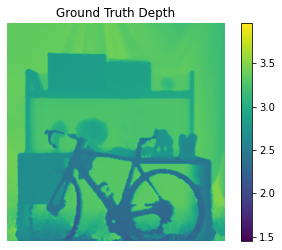

In [58]:
plt.imshow(depth_scaled)
plt.colorbar()
plt.title('Ground Truth Depth')
plt.axis('off');

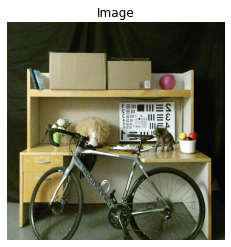

In [59]:
plt.imshow(rgb_cropped)
plt.axis('off')
plt.title('Image');

In [63]:
# Experiment setup
cond = 'diffuse'  # 'diffuse' or 'scanned'
n_sec = 1       # Integration time in sec for flash dataset
bin_width_ps = 16
bin_width_m = bin_width_ps * 3e8 / (2 * 1e12)
min_r = 0.8
max_r = 6.
min_depth_bin = np.floor(min_r / bin_width_m).astype('int')
max_depth_bin = np.floor(max_r / bin_width_m).astype('int')
# Create MDE and MDETransient
mde = MiDaS(model_path=Path('.')/'models'/'midas_backend'/'model.pt',
            full_width=rgb_cropped.shape[1],
            full_height=rgb_cropped.shape[0],
            min_depth=min_r,
            max_depth=max_r,
            device=device
)

mde_model = MDE(mde, key='midas_image',
                in_type='torch',
                in_order='nchw',
                out_type='numpy',
                out_order='nhwc')

preproc = TransientPreprocessor(n_sid_bins=300,
                                n_ambient_bins=100,
                                edge_coeff=5.,
                                n_std=1.
)
source_disc = SI(n_bins=300, alpha=min_r, beta=max_r)

mde_transient = MDETransient(mde_model=mde_model,
                             preproc=preproc,
                             refl_est=refl_est_green,
                             source_disc=source_disc,
                             min_depth=min_r,
                             max_depth=max_r,
                             crop=None,
                             radial=True,
                             fc=fc_kinect_rgb,
                             image_key='image',
                             transient_key='transient'
)

# Load SPAD
data = np.load(data_dir/f'{cond}_spad.npy')
if cond == 'diffuse':
    spad = np.sum(data[:n_sec, min_depth_bin:max_depth_bin], axis=0).astype(np.float32)
else:
    scan_dz = 0.01  # spad offset from calib/geometry.txt
    spad_dn = np.round(scan_dz/bin_width_m).astype(int)
    spad = np.sum(data[:, :, min_depth_bin-spad_dn:max_depth_bin-spad_dn], axis=(0, 1)).astype(np.float32)



In [64]:
# Run stuff
data = {
    'image': rgb_cropped,
    'depth': depth_scaled,
    'transient': spad
}
transform = Compose([
    midas_preprocess,
    to_tensor,
])
data = default_collate([transform(data)])
mde_pred = mde_model(data).numpy().squeeze()
transient_pred = mde_transient(data).numpy()

mde_diff = np.abs(mde_pred - depth_scaled)
transient_diff = np.abs(transient_pred - depth_scaled)

diff_norm = mpl.colors.Normalize(
    vmin=min(np.min(mde_diff), np.min(transient_diff)),
    vmax=max(np.max(mde_diff), np.max(transient_diff))
)

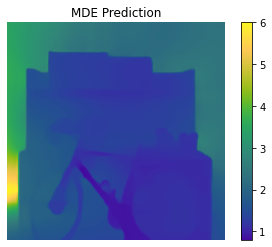

In [65]:
plt.imshow(mde_pred, cmap=parula)
plt.title('MDE Prediction')
plt.colorbar()
plt.axis('off');

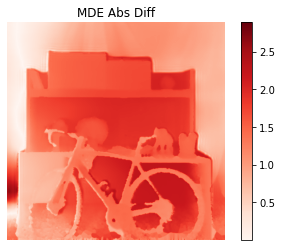

In [66]:
plt.imshow(mde_diff, cmap=mpl.cm.get_cmap('Reds'), norm=diff_norm)
plt.title('MDE Abs Diff')
plt.colorbar()
plt.axis('off');

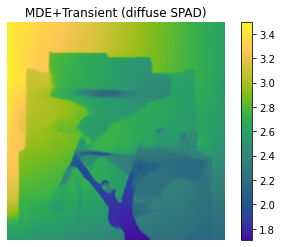

In [67]:
plt.imshow(transient_pred, cmap=parula)
plt.title(f'MDE+Transient ({cond} SPAD)')
plt.colorbar()
plt.axis('off');

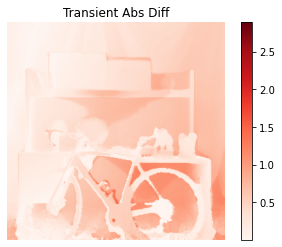

In [68]:
plt.imshow(transient_diff, cmap=mpl.cm.get_cmap('Reds'), norm=diff_norm)
plt.title('Transient Abs Diff')
plt.colorbar()
plt.axis('off');